In [9]:
from math import sqrt
import alpaca_trade_api as tradeapi
from datetime import datetime
import pytz
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import json
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.regularizers import l2
from keras.callbacks import EarlyStopping


# API credentials
api_key = 'AKQB26E5HLHLA54FOT9T'
api_secret = 'hNgAGISeVTThSFOoa1biaGcRuWYD8HvOvtb1AB7c'
base_url = 'https://paper-api.alpaca.markets'  

# Initialize the Alpaca API
api = tradeapi.REST(api_key, api_secret, base_url, api_version='v2')

symbol = 'SPY' 
start_date = datetime(2023, 1, 1).astimezone(pytz.timezone('UTC')) 
end_date = datetime(2024, 1, 1).astimezone(pytz.timezone('UTC'))  


daily_prices = api.get_bars(symbol, tradeapi.TimeFrame.Day, start_date.isoformat(), end_date.isoformat()).df
print(daily_prices)

#  ******************* ADDING SENITMENT DATA *******************

with open('temp.json', 'r') as file:
    sentiment_data = json.load(file)

sentiment_df = pd.DataFrame(list(sentiment_data.items()), columns=['date', 'sentiment'])
sentiment_df['date'] = pd.to_datetime(sentiment_df['date']).dt.tz_localize('UTC')


daily_prices.index = pd.to_datetime(daily_prices.index, utc=True)

combined_df = pd.merge(daily_prices, sentiment_df, how='inner', left_index=True, right_on='date')

print(combined_df.head())



                            close    high       low  trade_count    open  \
timestamp                                                                  
2023-01-03 05:00:00+00:00  380.82  386.43  377.8310       590240  384.37   
2023-01-04 05:00:00+00:00  383.76  385.88  380.0000       632808  383.18   
2023-01-05 05:00:00+00:00  379.38  381.84  378.7600       530899  381.72   
2023-01-06 05:00:00+00:00  388.08  389.25  379.4127       685781  382.61   
2023-01-09 05:00:00+00:00  387.86  393.70  387.6700       549428  390.37   
...                           ...     ...       ...          ...     ...   
2023-12-22 05:00:00+00:00  473.65  475.38  471.7000       485465  473.86   
2023-12-26 05:00:00+00:00  475.65  476.58  473.9900       348986  474.07   
2023-12-27 05:00:00+00:00  476.51  476.66  474.8900       425538  475.44   
2023-12-28 05:00:00+00:00  476.69  477.55  476.2600       374241  476.88   
2023-12-29 05:00:00+00:00  475.31  477.03  473.3000       604247  476.49   

           

In [10]:
X = daily_prices[['close', 'high', 'low', 'trade_count', 'open']]
X['high_low_percent'] = (X['high'] - X['low']) / X['low'] * 100
X['open_close_percent'] = (X['open'] - X['close']) / X['close'] * 100

X = X.drop('open', axis=1)
X = X.drop('close', axis=1)
X = X.drop('high', axis=1)
X = X.drop('low', axis=1)


# normalized data 
avg_vol = daily_prices['volume'].sum() / daily_prices.shape[0]

Y = daily_prices['volume'] / avg_vol


/var/folders/90/x6spqd2j4cbb38yrckqjm8840000gn/T/ipykernel_4866/2626257824.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['high_low_percent'] = (X['high'] - X['low']) / X['low'] * 100


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


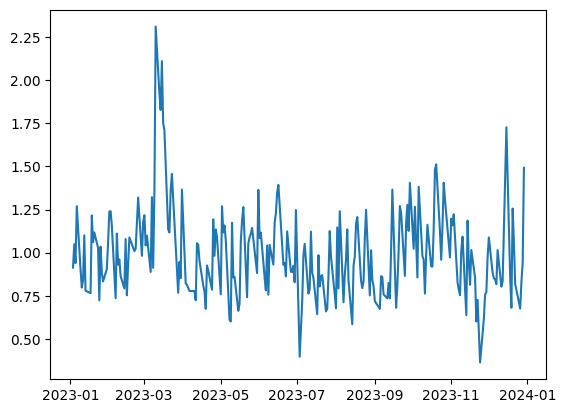

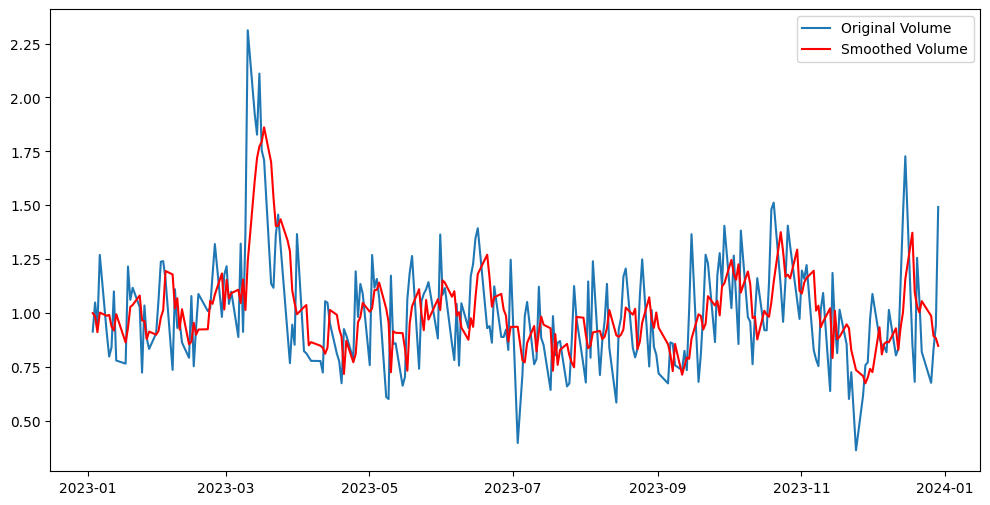

In [11]:
# Exponential Smoothing
model = ExponentialSmoothing(Y, trend="add", seasonal="add", seasonal_periods=12)
fitted_model = model.fit()

plt.plot(Y)
plt.show()

# Plot original data and smoothed data
plt.figure(figsize=(12, 6))
plt.plot(Y.index, Y, label='Original Volume')
plt.plot(Y.index, fitted_model.fittedvalues, label='Smoothed Volume', color='red')
plt.legend()
plt.show()

y_smooth = fitted_model.fittedvalues

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=40)

In [13]:
# DECISION TREE MODEL

regressor = DecisionTreeRegressor(random_state=40)
regressor.fit(X_train, y_train)

predictions = regressor.predict(X_test)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 0.013921899494770023
R-squared: 0.8397067634925317


In [14]:
# XGB BOOST MODEL

regressor = xgb.XGBRegressor(n_estimators=100, random_state=40)
regressor.fit(X_train, y_train)

predictions = regressor.predict(X_test)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


Mean Squared Error: 0.013067503180643356
R-squared: 0.8495440669799519


Mean Squared Error: 0.01178855676137576
R-squared: 0.8642695332096898


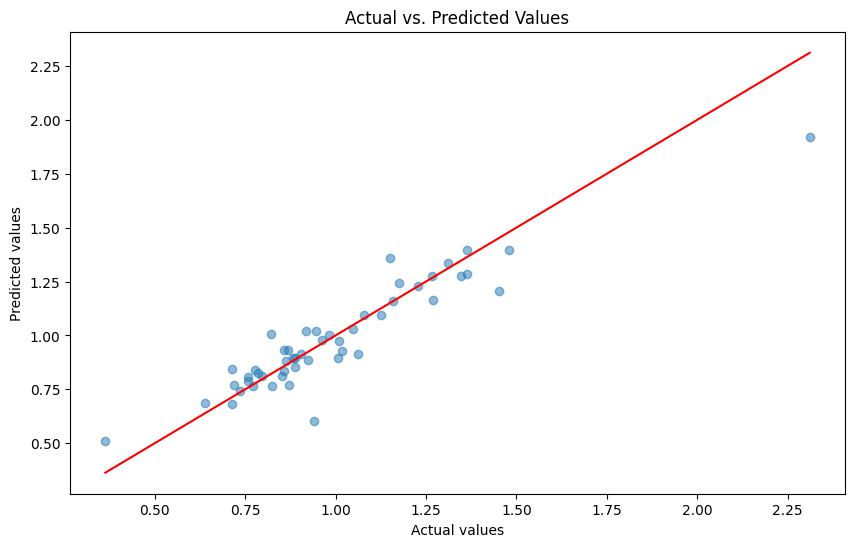

In [15]:
# FOREST MODEL

regressor = RandomForestRegressor(n_estimators=100, random_state=40)
regressor.fit(X_train, y_train)

predictions = regressor.predict(X_test)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.5)
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Diagonal line
plt.show()

Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4450422784.0000 - val_loss: 1054656320.0000
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 577867840.0000 - val_loss: 2890939.5000
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7502697.5000 - val_loss: 36551220.0000
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 27171008.0000 - val_loss: 3532157.2500
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1400805.0000 - val_loss: 828361.3125
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 782259.2500 - val_loss: 180181.8906
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 74591.2656 - val_loss: 32441.1465
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 30230.0059 - val_loss: 4298.2554
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1609.8103 - val_loss: 1885.4187
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1371.0935 - val_loss: 12.8778
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - los

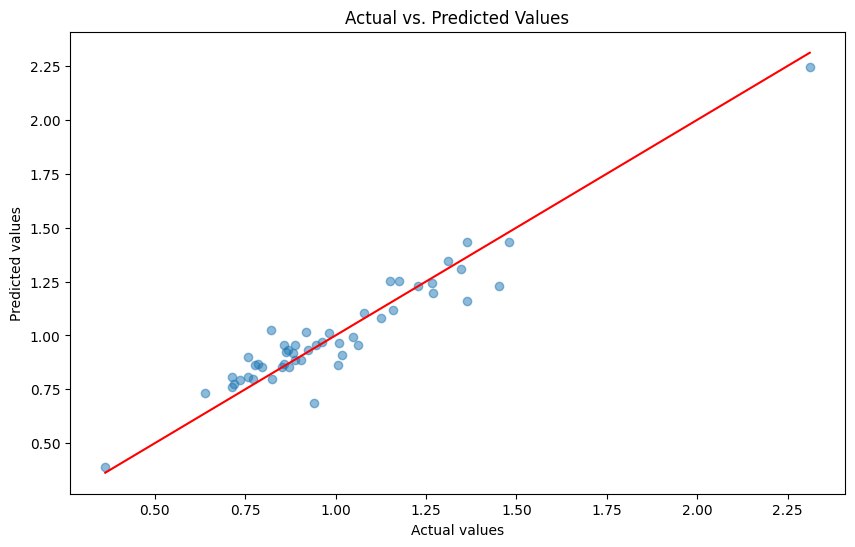

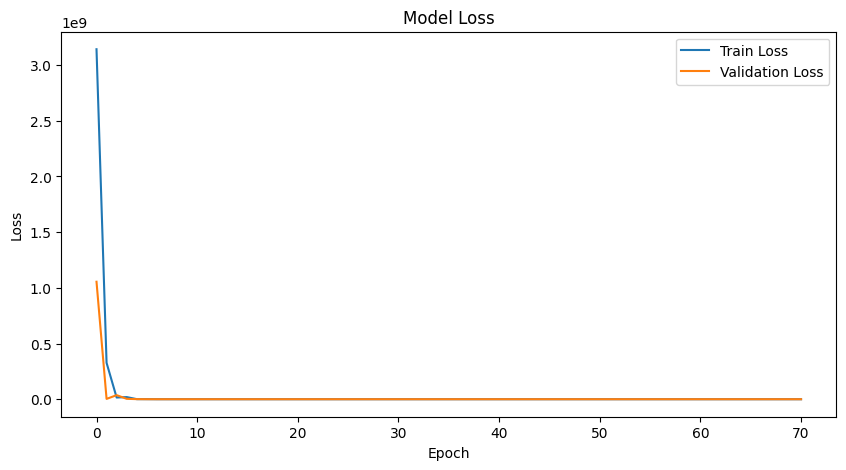

" # TRYING TO DO THIS FOR TODAY TO SEE ACCURACY\n\nformatted_end_date = end_date.strftime('%Y-%m-%d')\nformatted_start_date = start_date.strftime('%Y-%m-%d')\nstart_date = datetime(2024, 1, 1).astimezone(pytz.timezone('UTC')) \nend_date = datetime(2024, 3, 1).astimezone(pytz.timezone('UTC'))  \n\nmodel_prices = api.get_bars(symbol, tradeapi.TimeFrame.Day, formatted_start_date, formatted_end_date).df\nmodel_prices['high_low_percent'] = (model_prices['high'] - model_prices['low']) / model_prices['low'] * 100\nmodel_prices['open_close_percent'] = (model_prices['open'] - model_prices['close']) / model_prices['close'] * 100\n\n# Keep only the necessary columns for the model input\nmodel_prices_predict = model_prices[['high_low_percent', 'open_close_percent', 'trade_count']]\n\n# Keep the date and volume for reference\nreference_data = model_prices[['date', 'volume']]\n\n# Predict using the model\npredictions = model.predict(model_prices_predict)\npredictions = predictions.flatten()  # Flatt

In [16]:
# NEURAL NETWORK
import numpy as np
import random
from tensorflow import random as tf_random


model = Sequential([
    Dense(10, activation='relu', input_shape=(X_train.shape[1],)), 
    Dense(10, activation='relu'),
    Dense(1) 
])

np.random.seed(42)
random.seed(42)
tf_random.set_seed(42)

# Include callbacks for consistency in training performance
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train, y_train, epochs=100, batch_size=10, validation_split=0.2, callbacks=[early_stopping])

predictions = model.predict(X_test)

mse = mean_squared_error(y_test, predictions.flatten())
r2 = r2_score(y_test, predictions.flatten())

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.5)
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Diagonal line
plt.show()

# Plotting loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# Ensure this part is applicable only if you're tracking accuracy for a classification problem
if 'accuracy' in history.history:
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    plt.show()


""" # TRYING TO DO THIS FOR TODAY TO SEE ACCURACY

formatted_end_date = end_date.strftime('%Y-%m-%d')
formatted_start_date = start_date.strftime('%Y-%m-%d')
start_date = datetime(2024, 1, 1).astimezone(pytz.timezone('UTC')) 
end_date = datetime(2024, 3, 1).astimezone(pytz.timezone('UTC'))  

model_prices = api.get_bars(symbol, tradeapi.TimeFrame.Day, formatted_start_date, formatted_end_date).df
model_prices['high_low_percent'] = (model_prices['high'] - model_prices['low']) / model_prices['low'] * 100
model_prices['open_close_percent'] = (model_prices['open'] - model_prices['close']) / model_prices['close'] * 100

# Keep only the necessary columns for the model input
model_prices_predict = model_prices[['high_low_percent', 'open_close_percent', 'trade_count']]

# Keep the date and volume for reference
reference_data = model_prices[['date', 'volume']]

# Predict using the model
predictions = model.predict(model_prices_predict)
predictions = predictions.flatten()  # Flatten the predictions if necessary

# Combine predictions with reference data
reference_data['predictions'] = predictions

# Print or save the combined data
print(reference_data) """


In [17]:
# DECISION TREE MODEL AND SMOOTHED

X_train, X_test, y_train, y_test = train_test_split(X, y_smooth, test_size=0.2, random_state=40)

regressor = DecisionTreeRegressor(random_state=40)
regressor.fit(X_train, y_train)

predictions = regressor.predict(X_test)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print(f"Mean Squared Error: {sqrt(mse)}")
print(f"R-squared: {r2}")

Mean Squared Error: 0.17078321963168183
R-squared: -0.24055302159941006


In [18]:
# XGB BOOST MODEL and SMOOTHED

X_train, X_test, y_train, y_test = train_test_split(X, y_smooth, test_size=0.2, random_state=40)

regressor = xgb.XGBRegressor(n_estimators=100, random_state=40)
regressor.fit(X_train, y_train)

predictions = regressor.predict(X_test)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print(f"Mean Squared Error: {sqrt(mse)}")
print(f"R-squared: {r2}")

Mean Squared Error: 0.15363551850726198
R-squared: -0.003941017725784812


In [19]:
# FOREST MODEL AND SMOOTHED

X_train, X_test, y_train, y_test = train_test_split(X, y_smooth, test_size=0.2, random_state=40)

regressor = RandomForestRegressor(n_estimators=100, random_state=40)
regressor.fit(X_train, y_train)

predictions = regressor.predict(X_test)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print(f"Mean Squared Error: {sqrt(mse)}")
print(f"R-squared: {r2}")

Mean Squared Error: 0.14041971266417125
R-squared: 0.16134933140485175
